# Evaluating the Robustness of Interpretability Methods through Explanation Invariance and Equivariance'

The paper which I am re-implementing introduce an evaluation metric to test the robustness of the explanation. 

The quality of robustness is tipically associated to the idea that, when performing a transformation to the input, the explanation should not change significantly (see e.g. the "continuity" evaluation in Nauta et al. 2023). In this work, they focus on transformations based on symmetries which are respected by the models. The assumption is that, if the output of a model is invariant under a certain symmetry, the corresponding explanation should also be invariant or equivariant, depending on the type of explanation.

The example I focus in this re-implementation is that of Graph Neural Networks. Many of these models, in the case of graph-level tasks, are notoriously invariant under node permutation, i.e. the output remains the same. A corresponding attribution on the node features should therefore be equivariant under a node permutation: the important features of a specific node should remain the same. In other words, given a fixed node permutation $P$ and a graph $G$, the explanation of a permuted graph $e(P(G))$, and the permuted explanation of the original graph $P'(e(G))$ should be the same (where $P$ and $P'$ might be differently defined depending on the domain of the explanation, but corresponding to the same permuation).

When the attribution does not respect the original symmetry, the authors also propose a systematic approach to make an attribution more robust, by aggregrating all the explanations produced when performing all possible transformations in a given symmetry group on the data. They prove that the attribution produced in this way should always be equivariant. However, as in the case of node permutations, the number of possible transformations can very large, even if finite, and the equivariant explanation can only be approximated by a Monte Carlo estimation.

In this example, I test the equivariance requirement on 4 attribution explainers: GNNExplainer, Integrated Gradients, Deconvolution and GradientSHAP. I reproduce the original model and test of the paper and the main result of their experiment with a GNN trained on the Mutagenicity dataset. Moreover, since GradientSHAP shows to be not equivariant, I also test the proposed method to enforce equivariant explanations.

# Code

## First import

In [1]:
# import of libraries and utilities

import torch
import torch_geometric as tg
from torch_geometric import seed_everything
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.append('../src')

# import of my code
from dataloader import load_mutagenicity
from model import MUTAG_GNN
from explainers import *
from train import train, accuracy
from utils import equivariance_robustness




/Users/francescopaolonerini/anaconda3/envs/pyg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading of data, model and training

In [2]:
# data loading of mutagenicity dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, testloader = load_mutagenicity(device=device, seed = 3003)


In [3]:
# training of the model, using the same parameters as in the paper
# the early stopping is tested on the test set since "the model generalization is never used as an evaluation criterion."
# (they literally wrote this in the paper)

gnn = MUTAG_GNN()
gnn.to(device)

logs = train(gnn, trainloader, testloader, epochs=200, lr=1e-3, weight_decay=1e-5, patience=20)

gnn.eval()

print('Final accuracy on test set: {:.2f}'.format(accuracy(gnn, testloader)))

Epoch 0 - Training loss: 1.337838888168335; Test loss: 0.8272989392280579; Test accuracy: 0.5607833771196561
Epoch 1 - Training loss: 0.6814165115356445; Test loss: 0.6713846921920776; Test accuracy: 0.5741581084308575
Epoch 2 - Training loss: 0.6369482278823853; Test loss: 0.6497127413749695; Test accuracy: 0.619775495581562
Epoch 3 - Training loss: 0.5818501710891724; Test loss: 0.6309210658073425; Test accuracy: 0.6345832338189634
Epoch 4 - Training loss: 0.5405450463294983; Test loss: 0.6355844736099243; Test accuracy: 0.6319560544542632
Epoch 5 - Training loss: 0.5092921257019043; Test loss: 0.6490525007247925; Test accuracy: 0.6419871029376641
Epoch 6 - Training loss: 0.5016511678695679; Test loss: 0.6736912727355957; Test accuracy: 0.6384045856221638
Epoch 7 - Training loss: 0.4936051368713379; Test loss: 0.6723114252090454; Test accuracy: 0.6431812753761643
Epoch 8 - Training loss: 0.47835737466812134; Test loss: 0.6605879664421082; Test accuracy: 0.6563171721996657
Epoch 9 - T

## Testing explainers



In [4]:
# we use four explainers: GNNExplainer, Integrated Gradients, GradientShap and Deconvolution
# GNNExplainer and Deconvolution are not used in the paper, but we include them for comparison

# NOTE: GNNExplainer is very slow, and it is not recommended to run it on CPU.


explainers = [
    gnnexp_scores(model=gnn, device=device),
    captum_scores(model=gnn, device=device, explainer_name='IntegratedGradients'),
    captum_scores(model=gnn, device=device, explainer_name='GradientShap', baseline_type='zeros'),
    captum_scores(model=gnn, device=device, explainer_name='GradientShap', baseline_type='ones'),
    captum_scores(model=gnn, device=device, explainer_name='Deconvolution'),
]
    

In [5]:
results = {}


# we select a single batch of the test set with enogh nodes to test the equivariance robustness


# for each explainer we compute the equivariance robustness
# the equivariance robustness is computed with respect to the feature attribution scores 
# and averaged across the databatches in testloader


for explainer in explainers:
    explainer_name = explainer.explainer_name
    print('Testing:', explainer_name)
    if explainer_name == 'GradientShap':
        explainer_name = f'GradientSHAP_{explainer.baseline_type}'
    results[explainer_name] = equivariance_robustness(testloader, explainer)


Testing: GNNExplainer


  4%|▍         | 2/50 [07:03<2:49:35, 211.99s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Explanation Equivariance')

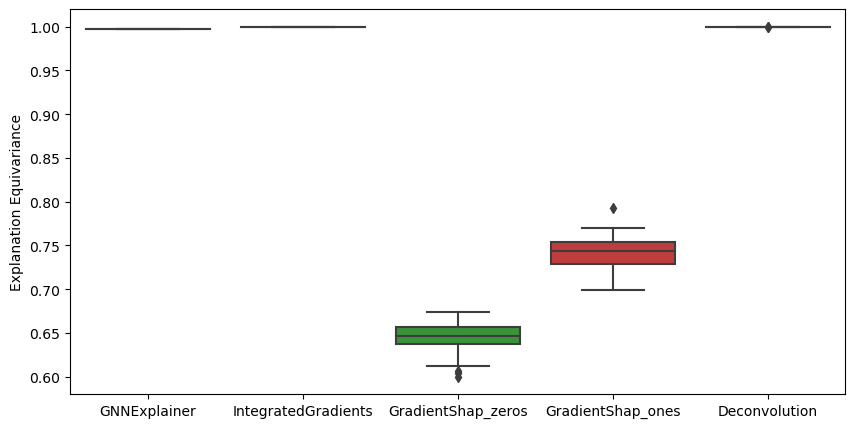

In [ ]:
# lastly we plot the results using a boxplot


results = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=results, ax=ax)

ax.set_ylabel('Explanation Equivariance')

fig.savefig('mutag_equivariance.png')

## Enforcing equivariant explanations

In [ ]:
# first we define our explainer, which must have an explain method which takes the data as input
gradientSHAP = captum_scores(model=gnn, device=device, explainer_name='GradientShap', baseline_type='zeros')

# we wrap the explainer in the equivariant_explainer class, which will enforce the equivariance property
# by averaging the explanations scores after permuting n_perms times the input data

equivariant_gradientSHAP = equivariant_explainer(model=gnn, original_explainer=gradientSHAP, n_perms=50)

robustness_scores  = equivariance_robustness(testloader, equivariant_gradientSHAP)

print('Mean Equivariance Robustness of GradientSHAP after correction:', robustness_scores.mean())



100%|██████████| 50/50 [1:17:12<00:00, 92.66s/it] 

Equivariance Robustness of GradientSHAP after correction: [0.99281033 0.99251356 0.99336271 0.99201895 0.99150314 0.99213333
 0.99256234 0.9927558  0.99198723 0.99205179 0.99235765 0.99275369
 0.99239187 0.99156025 0.99323458 0.99212592 0.9929313  0.99211253
 0.99273503 0.99305533 0.99315359 0.99206559 0.99279164 0.99304292
 0.99264633 0.99170607 0.99267672 0.99244252 0.99171457 0.99323548
 0.99305648 0.99252417 0.99255684 0.99294789 0.9932049  0.9918775
 0.9926032  0.9918919  0.99213602 0.99233904 0.99292224 0.99278279
 0.9930789  0.99362934 0.99332455 0.99262502 0.9927404  0.9915994
 0.99262228 0.99311238]


In [ ]:
results_compare = {
    'GradientSHAP': results['GradientSHAP_zeros'],
    'equivariant_GradientSHAP': robustness_scores
}

results_compare = pd.DataFrame(results_compare)

fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=results_compare, ax=ax)

ax.set_ylabel('Explanation Equivariance')

fig.savefig('compare_gradientSHAP.png')

# Results summary

The results are in line with what was reported on the paper. GradientSHAP is the only attribution explainer which produce explanations which are not equivariant with respect to a node permutation with both a baseline tensor of zeros (as in the original paper) and a baseline tensor of ones.

The two explainers which I introduced in the benchmark, GNNExplainer and Deconvolution, prove to be exactly robust with respect to the equivariance metric. While all the other explainers are based on gradients, GNNExplainer is a perturbation explainer which shows that also this category can produce robust explanations.

Regarding GradientSHAP, it's interesting that changing the baseline improve the results: it could be that choosing the right baseline may allow to obtain even more robust explanations. However, by following the paper guidelines and enforcing the equivariance of the explainers, we can always produce equivariant explanations even from GradientSHAP.